In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import networkx as nx
from matplotlib.patches import FancyArrowPatch
from matplotlib.colors import ListedColormap

# Emergent Dominance Hierarchies in Reinforcement Learning Agents

This paper [link](https://arxiv.org/abs/2401.12258) shows that in a stochastic game of Chicken RL agents will learn, enforce, and transmit dominance hierachies as an equilibrium strategy. 

The game of Chicken has the following payoffs:

$
\begin{array}{c|cc}
\text{} & \text{Hawk} & \text{Dove} \\
\hline
\text{Hawk} & C,C & W,L \\
\text{Dove} & L,W & T,T \\
\end{array}
$

Where the labels are Win, Tie, Lose, and Crash. The payoffs are such that $W>T>L>C$.

This game has two equilibria, at ($L$,$W$) and ($W$,$L$).

Each agent is given their own neural network in the original paper. The input just the other agent's index. 

I'm going to deviate for simplicity a bit here and simply model a probability of playing Hawk given the opponent. If two players meet with probabilities $p_1$ and $p_2$ the payoff for player 1 will be:

$$p_1p_2C+p_1(1-p_2)W+(1-p1)p_2L+(1-p_1)(1-p_2)T$$

Which expanded is:

$$p_1p_2C+p_1W-p_1p_2W+p_2L-p1p_2L+T-p_1T-p_2T+p_1p_2T$$

Giving a gradient wrt $p_1$ of:

$$p_2C+W-p_2W-p_2L-T+p_2T$$

Which can be refactored as:

$$p_2(C-W-L+T)+(W-T)$$

We can see this using an example where $C=1$, $W=4$, $L=2$, $T=3$: 

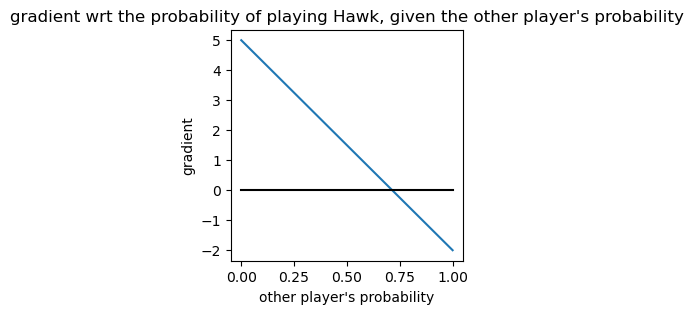

In [108]:
C,W,L,T = 1,10,3,5
p2 = np.linspace(0,1,100)
gradient = p2*(C-W-L+T)+(W-T)
plt.figure(figsize=(3,3))
plt.plot(p2,gradient)
plt.plot([0,1],[0,0],color="black")
plt.title("gradient wrt the probability of playing Hawk, given the other player's probability")
plt.xlabel("other player's probability")
plt.ylabel("gradient")
plt.show()

In this particular case the gradient says to increase the probability of Hawk if the other player is less than ~0.75, otherwise decrease it.

This means we can simply update the probabilities with gradient descent:

In [191]:
def run_game(N, lr, C, W, L, T, epochs, n):    
    # linear gradient function
    w = C - W - L + T
    b = W - T

    # random initialization
    p = np.random.rand(N, N)
    np.fill_diagonal(p, 0)

    # aggression is the mean learned p
    aggression_history = []
    rapport_history = []
    
    for epoch in range(epochs):
        aggression_history.append(np.sum(p,axis=1)/(N-1)) # ignore self
        rapport_history.append(np.sum(np.abs(p-p.T)>n)/(N**2-N)) # average over whether there is dominance
        p_grad = p.T*w+b # transpose to get the OTHER GUY'S probability
        p+=p_grad*lr
        np.clip(p, 0, 1, out=p)
        np.fill_diagonal(p, 0) # in case these changed

    dominance = p>(p.T+n)

    return np.array(aggression_history), np.array(rapport_history), p, dominance

And a function to plot history and dominance (with a minimum difference, n)...

In [192]:
def plot_combined(aggression_history, rapport_history, p, dominance):
    p = np.copy(p)
    
    N = len(p)
    fig = plt.figure(figsize=(16, 10))
    
    # Create a 2x2 grid with different height ratios
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1], height_ratios=[1, 1])

    # First row - Summary plots
    ax1 = fig.add_subplot(gs[0, 0])  # Line plot
    ax2 = fig.add_subplot(gs[0, 1])  # Probability matrix
    
    # Second row - Dominance Network
    ax3 = fig.add_subplot(gs[1, 0])  # Network plot
    ax4 = fig.add_subplot(gs[1, 1])  # Dominance matrix

    # Create consistent colors for all players
    colors = plt.cm.Set3(np.linspace(0, 1, N))
    
    # ===== First Row: Summary Plots =====
    # Line Plot with matching colors
    for i in range(N):
        ax1.plot(aggression_history[:, i], lw=5, color=colors[i], label=f'P{i}')
    ax1.plot(rapport_history,color="red",lw=5, label="rapport")
    ax1.set_ylim(0,1.05)
    ax1.set_title("Average probability of playing Hawk over time", fontsize=14)
    ax1.set_xlabel("Time (epochs/10)")
    ax1.set_ylabel("Probability")
    ax1.grid(True, alpha=0.3)
    ax1.legend()

    # Matrix Plot
    np.fill_diagonal(p, 1)
    im = ax2.imshow(p, cmap="gray", vmin=0, vmax=1)
    for i in range(N):
        ax2.plot([i - 0.2, i + 0.2], [i - 0.2, i + 0.2], color='red', lw=2)
        ax2.plot([i - 0.2, i + 0.2], [i + 0.2, i - 0.2], color='red', lw=2)
    
    ax2.set_title("Hawk Probability", fontsize=14)
    ax2.set_xlabel("Opponent")
    ax2.set_ylabel("Player")

    ax2.set_xticks(range(N))
    ax2.set_yticks(range(N))
    ax2.set_xticklabels([f"P{i}" for i in range(N)])
    ax2.set_yticklabels([f"P{i}" for i in range(N)])
    ax2.tick_params(labelsize=10)

    # ===== Second Row: Dominance Network =====    
    # Hierarchical Layout based on dominance level
    dominance_counts = np.sum(dominance, axis=1)  # How many others each node dominates
    max_dominance = np.max(dominance_counts) if np.max(dominance_counts) > 0 else 1
    
    # Create levels based on dominance count
    levels = {}
    for count in range(int(max_dominance), -1, -1):  # Changed to go from highest to lowest
        levels[count] = []
    
    for i, count in enumerate(dominance_counts):
        levels[int(count)].append(i)
    
    # Position nodes hierarchically (top to bottom)
    positions = {}
    num_levels = len(levels)
    
    # Calculate y-spacing to fit all levels comfortably
    if num_levels > 1:
        y_range = 4.0  # Total vertical range
        y_spacing = y_range / (num_levels - 1)
        y_top = 2.0    # Highest level at top
        y_bottom = y_top - y_range
    else:
        y_top = 0
        y_bottom = 0
        y_spacing = 0
    
    for level, nodes in levels.items():
        if num_levels > 1:
            y = y_top - (max_dominance - level) * y_spacing  # Highest dominance at top
        else:
            y = 0  # Single level, center it
            
        if len(nodes) == 1:
            x_positions = [0]
        else:
            x_positions = np.linspace(-2, 2, len(nodes))
        
        for i, node in enumerate(nodes):
            positions[node] = (x_positions[i], y)
    
    # Convert to list format for compatibility
    positions_list = [positions[i] for i in range(N)]

    for i, (x, y) in enumerate(positions_list):
        # Node size based on dominance count for additional visual emphasis
        node_size = 0.25 + 0.15 * (dominance_counts[i] / max_dominance) if max_dominance > 0 else 0.25
        circle = plt.Circle((x, y), node_size, color=colors[i], ec='black', lw=3)
        ax3.add_patch(circle)
        ax3.text(x, y, str(i), ha='center', va='center', fontsize=16, fontweight='bold')
        
        # Add dominance count as small text below node
        ax3.text(x, y - node_size - 0.2, f'({int(dominance_counts[i])})', 
                ha='center', va='center', fontsize=10, alpha=0.7)

    for i in range(N):
        for j in range(N):
            if dominance[i, j]:
                x1, y1 = positions_list[i]
                x2, y2 = positions_list[j]
                dx, dy = x2 - x1, y2 - y1
                dist = np.hypot(dx, dy)
                if dist > 0:  # Avoid division by zero
                    dxn, dyn = dx / dist, dy / dist
                    node_size_i = 0.25 + 0.15 * (dominance_counts[i] / max_dominance) if max_dominance > 0 else 0.25
                    node_size_j = 0.25 + 0.15 * (dominance_counts[j] / max_dominance) if max_dominance > 0 else 0.25
                    start = (x1 + (node_size_i + 0.05) * dxn, y1 + (node_size_i + 0.05) * dyn)
                    end = (x2 - (node_size_j + 0.05) * dxn, y2 - (node_size_j + 0.05) * dyn)
                    arrow = FancyArrowPatch(start, end,
                                            connectionstyle="arc3,rad=0.1",
                                            arrowstyle='->', mutation_scale=20,
                                            color='red', lw=3, alpha=0.8)
                    ax3.add_patch(arrow)

    ax3.set_xlim(-3, 3)
    # Dynamic y-limits based on actual node positions AND node sizes
    all_y_positions = [pos[1] for pos in positions_list]
    # Calculate the maximum node size to account for node radius
    max_node_size = 0.25 + 0.15 if max_dominance > 0 else 0.25
    y_min = min(all_y_positions) - max_node_size - 0.5  # Extra space below lowest node + node radius
    y_max = max(all_y_positions) + max_node_size + 0.5  # Extra space above highest node + node radius
    ax3.set_ylim(y_min, y_max)
    ax3.set_aspect('equal')
    ax3.axis('off')
    ax3.set_title("Dominance Hierarchy", fontsize=14)

    # Matrix View
    cmap = ListedColormap(['white', 'darkred'])
    ax4.imshow(dominance.astype(int), cmap=cmap, vmin=0, vmax=1)
    ax4.set_title("Dominance Matrix\n(Row dominates Column)", fontsize=14)
    ax4.set_xlabel("Opponent")
    ax4.set_ylabel("Player")

    for i in range(N):
        for j in range(N):
            if dominance[i, j]:
                ax4.text(j, i, '⬇', ha='center', va='center',
                         fontsize=24, fontweight='bold', color='white')
                ax4.add_patch(plt.Rectangle((j-0.4, i-0.4), 0.8, 0.8,
                                            fill=False, edgecolor='yellow', lw=3))

    ax4.set_xticks(range(N))
    ax4.set_yticks(range(N))
    ax4.set_xticklabels([f"P{i}" for i in range(N)])
    ax4.set_yticklabels([f"P{i}" for i in range(N)])
    ax4.tick_params(labelsize=10)

    plt.tight_layout()
    plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Adjust spacing between subplots
    plt.show()

We can see what happens in the case where nobody ever makes a mistake:

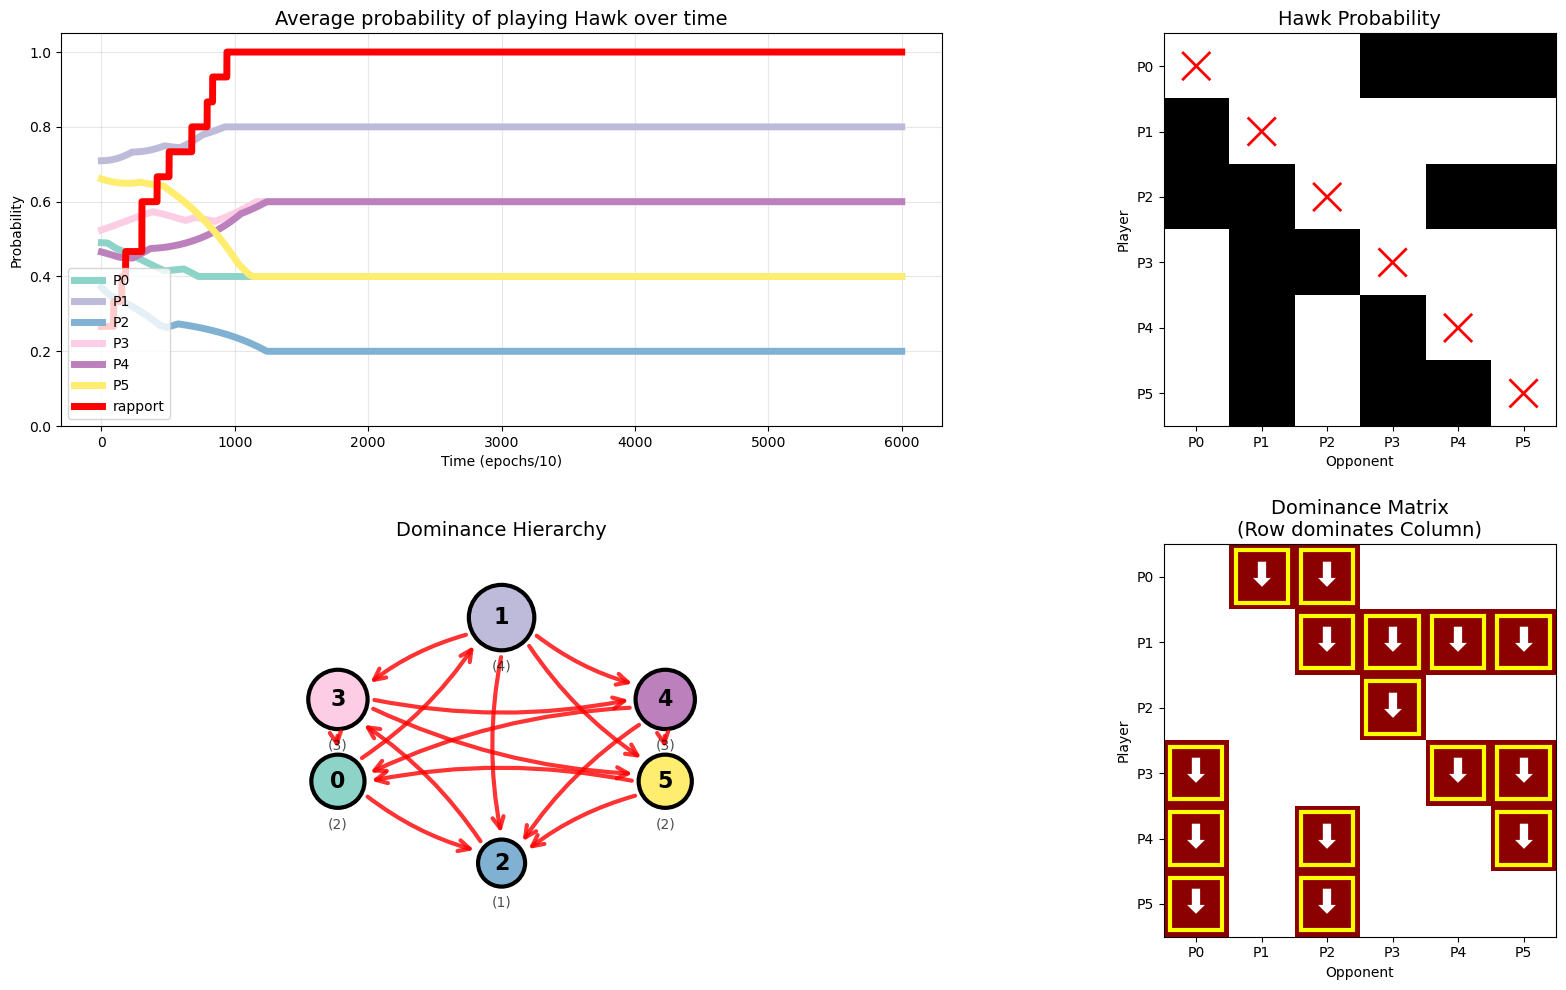

In [297]:
aggression_h, rapport_h, p, dominance = run_game(N=6, lr=0.001, C=1, W=4, L=2, T=3, epochs=6000, n=0.55)
plot_combined(aggression_h, rapport_h, p, dominance)

You can see the emergence of dominance here as all probabilities tend to 0 or 1 with all players doing the opposite of eachother. But this isn't so much of a *hierachy* as it is just random assignment. There are loops! 

The paper then goes on to consider errors in the identification of opponents. An error in identification basically just means applying the gradient to the wrong place, or getting the wrong gradient. If we assume this happens $x$% of the time and the misidentification is random then we just need to change our gradient update to use $x$ of the *mean* gradient and $1-x$ of the true gradient for each opponent:

In [203]:
def run_game_with_randomness(N, lr, C, W, L, T, epochs, n, x):    
    # linear gradient function
    w = C - W - L + T
    b = W - T

    # random initialization
    p = np.random.rand(N, N)
    np.fill_diagonal(p, 0)

    # aggression is the mean learned p
    aggression_history = []
    rapport_history = []
    
    for epoch in range(epochs):
        aggression_history.append(np.sum(p,axis=1)/(N-1)) # ignore self
        rapport_history.append(np.sum(np.abs(p-p.T)>n)/(N**2-N)) # average over whether there is dominance
        p_grad = p.T*w+b # transpose to get the OTHER GUY'S probability
        mean_p_grad = np.sum(p_grad,axis=1)/(N-1)
        p+=(mean_p_grad.reshape(1,-1)*x+p_grad*(1-x))*lr
        np.clip(p, 0, 1, out=p)
        np.fill_diagonal(p, 0) # in case these changed

    dominance = p>(p.T+n)

    return np.array(aggression_history), np.array(rapport_history), p, dominance

Fully random case:

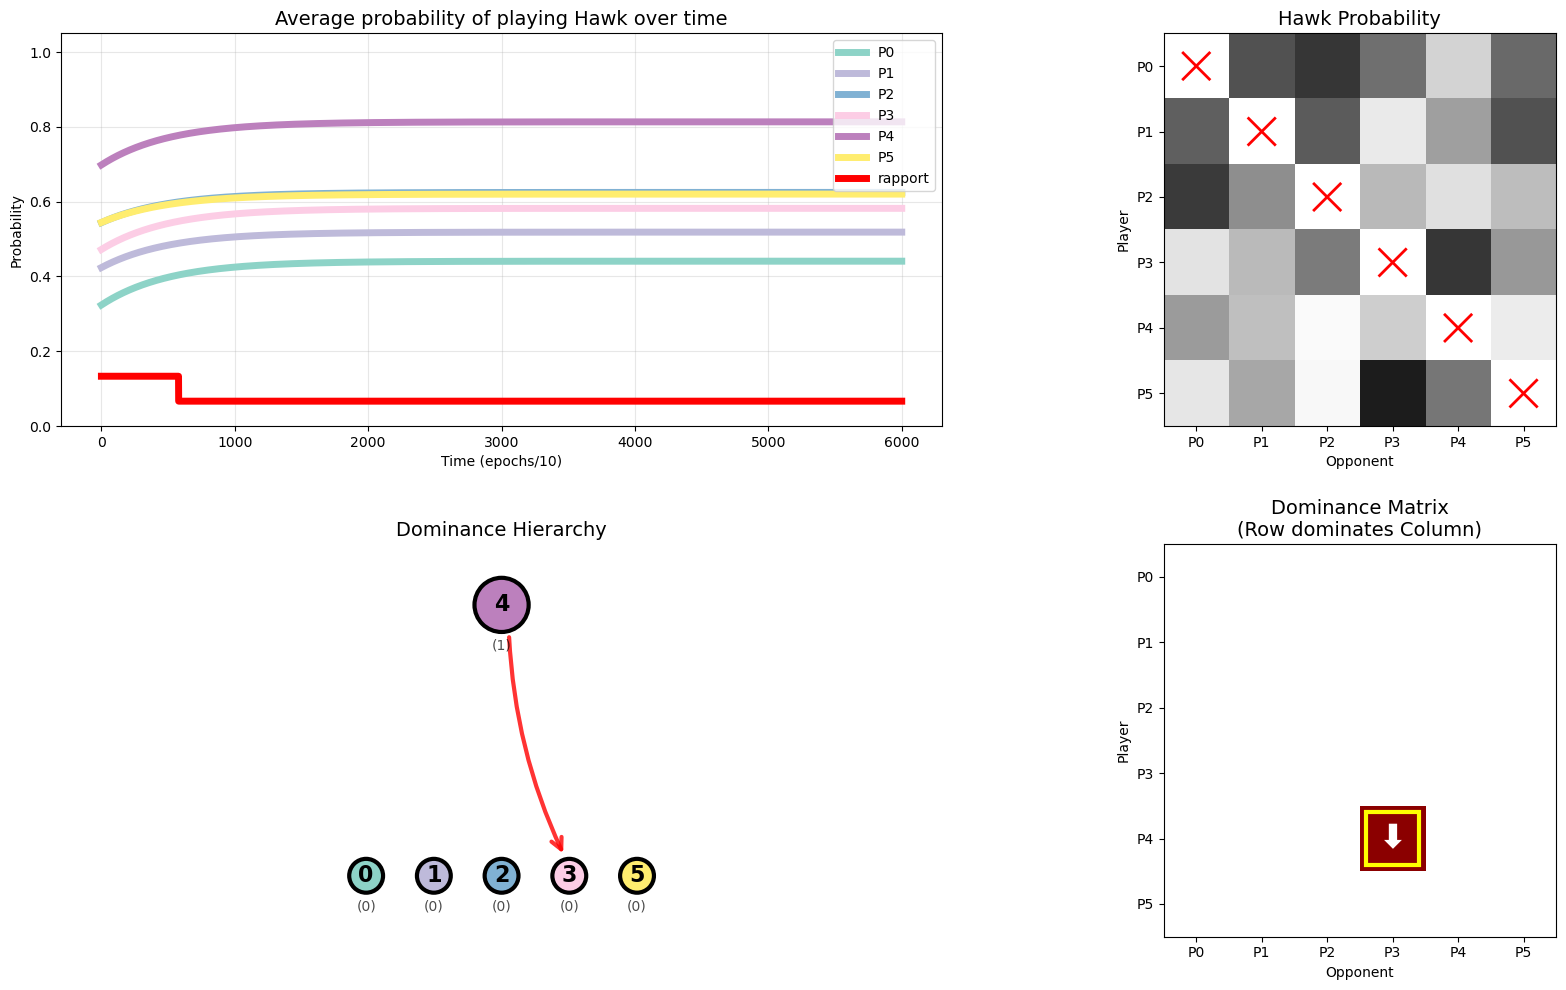

In [282]:
aggression_h, rapport_h, p, dominance = run_game_with_randomness(N=6, lr=0.001, C=1, W=4, L=2, T=3, epochs=6000, n=0.55,x=1.0)
plot_combined(aggression_h, rapport_h, p, dominance)

Somewhat random case:

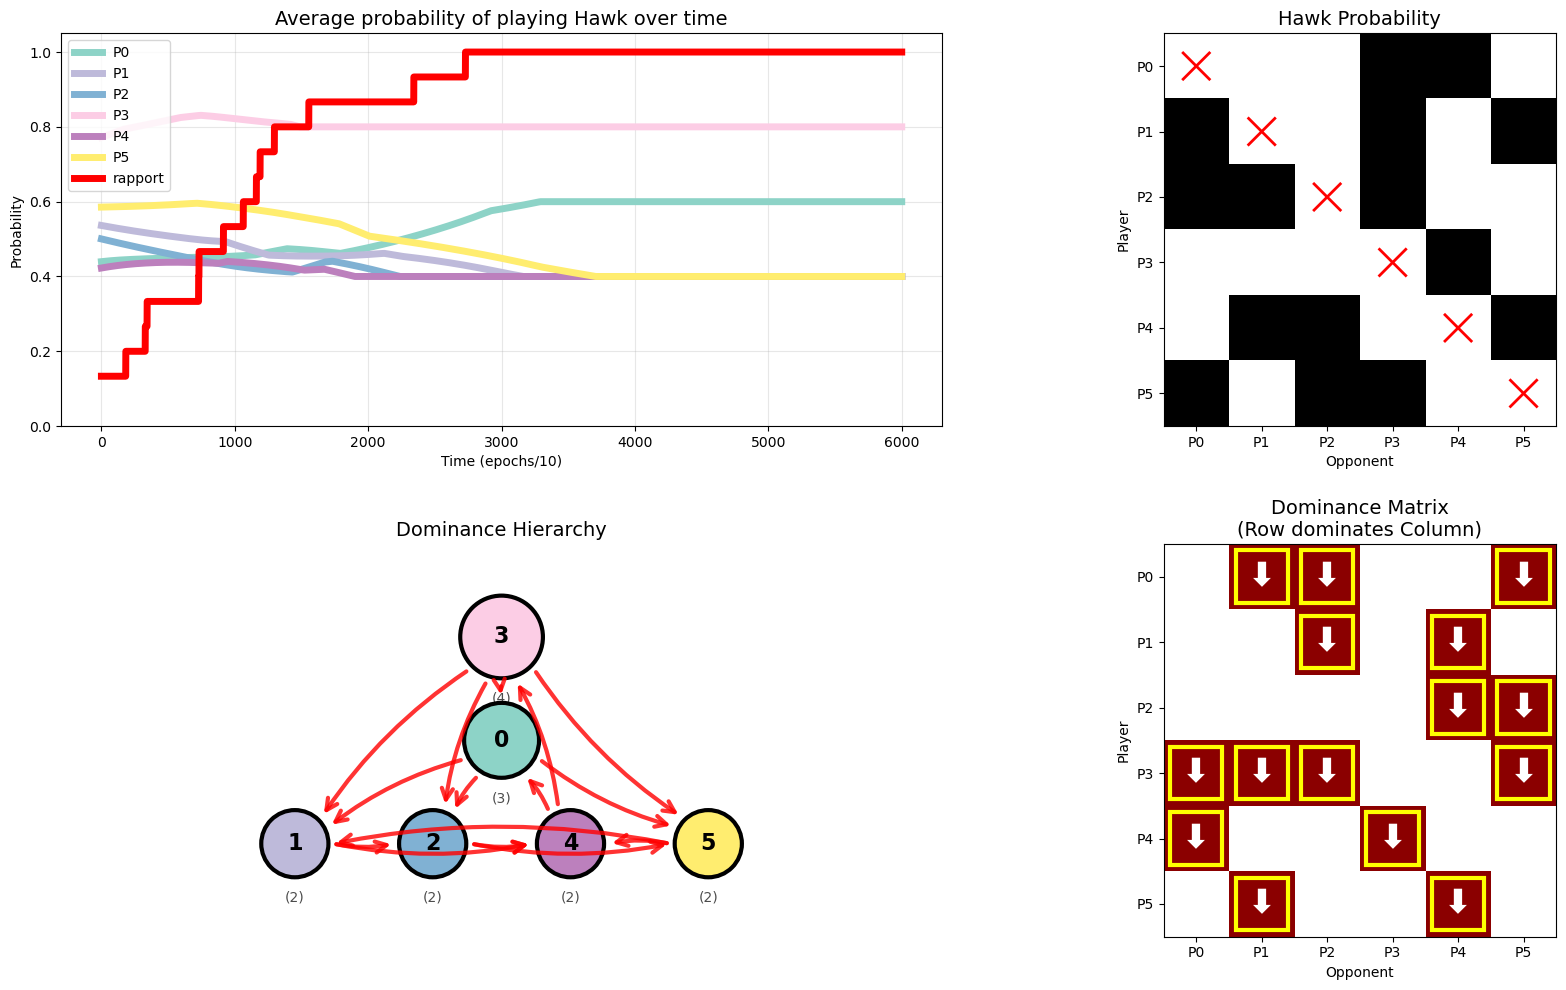

In [283]:
aggression_h, rapport_h, p, dominance = run_game_with_randomness(N=6, lr=0.001, C=1, W=4, L=2, T=3, epochs=6000, n=0.55,x=0.5)
plot_combined(aggression_h, rapport_h, p, dominance)

I suspect that the reason the original paper got more 'hierachial' results is just because they used a neural network to do the work instead of modelling a probability for each independently. Pushing one bias up because of one interaction also pushes it up for others! Here I will try adding a learnable bias variable per model which will be added to p to get the new probabilities. If this is 0 we get the behaviour above, but if not...

In [308]:
def run_game_with_randomness_and_bias(N, lr, C, W, L, T, epochs, n, x):    
    # linear gradient function
    w = C - W - L + T
    b = W - T

    # random initialization
    individual_shift = np.random.normal(0.25,0.5,(N,N))
    aggression = np.random.normal(0.25,0.5,N)
    p = individual_shift+aggression
    np.clip(p, 0, 1, out=p)
    np.fill_diagonal(p, 0)

    # aggression is the mean learned p
    aggression_history = []
    rapport_history = []
    
    for epoch in range(epochs):
        aggression_history.append(np.sum(p,axis=1)/(N-1)) # ignore self
        rapport_history.append(np.sum(np.abs(p-p.T)>n)/(N**2-N)) # average over whether there is dominance
        p_grad = p.T*w+b # transpose to get the OTHER GUY'S probability
        mean_p_grad = np.sum(p_grad,axis=1)/(N-1)
        combined_grad_wrt_p=(mean_p_grad.reshape(1,-1)*x+p_grad*(1-x))
        gradient_wrt_individual_shift = combined_grad_wrt_p
        gradient_wrt_aggression = np.sum(combined_grad_wrt_p,axis=1)
        individual_shift+=gradient_wrt_individual_shift*lr
        aggression+=gradient_wrt_aggression*lr
        p = individual_shift+aggression
        np.clip(p, 0, 1, out=p)
        np.fill_diagonal(p, 0) # in case these changed

    dominance = p>(p.T+n)

    return np.array(aggression_history), np.array(rapport_history), p, dominance

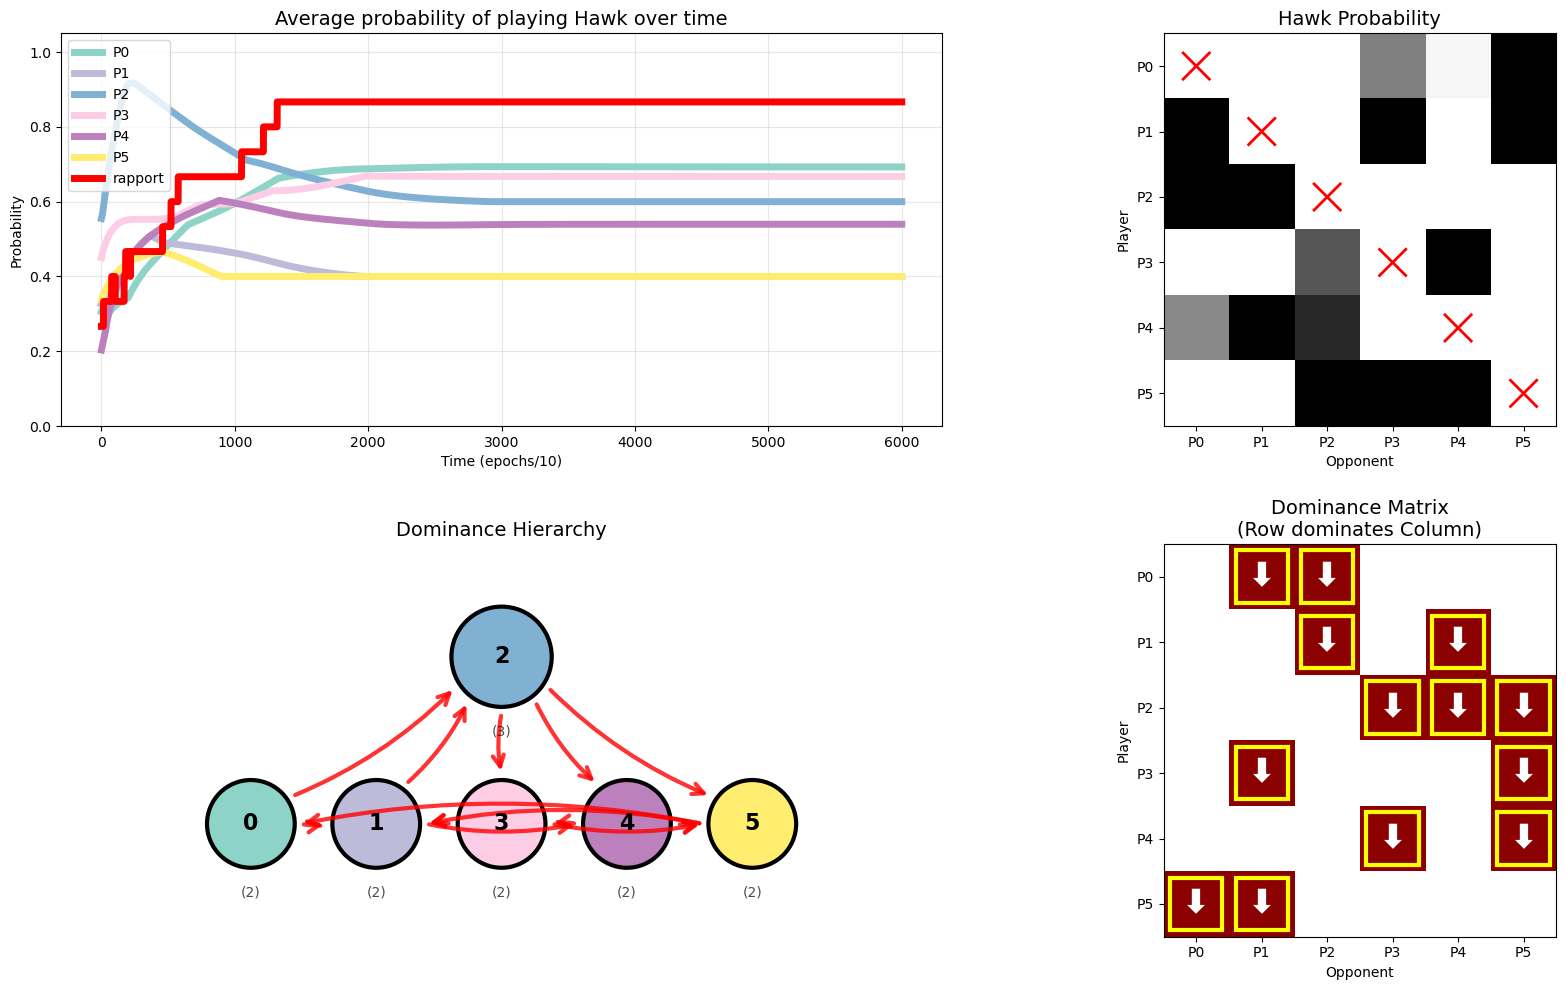

In [309]:
aggression_h, rapport_h, p, dominance = run_game_with_randomness_and_bias(N=6, lr=0.001, C=1, W=4, L=2, T=3, epochs=6000, n=0.55,x=0.0)
plot_combined(aggression_h, rapport_h, p, dominance)

The hierachies that you get down here are definitely different! All that has changed is instead of having a plain parameter per node I am now having an average (the 'aggression' actually) and a shift-per-opponent. This model has the exact same capacity, but gradient descent produces different results. All I am doing is splitting up the probability-per-person into a shift-per-person and a mean, but this changes it a lot! I think because the probabilities are no longer moving independently.
